# TICL Trackster Smoothing

This notebook builds a labeled dataset for identifying complete and incomplete tracksters.

In [1]:
import uproot
import numpy as np
from utils.plotting_utils import plot_event
from utils.matching_utils import split_on_shared_energy, get_eid_splits, get_pairs, get_highest_energy_fraction_simtracksters

%matplotlib inline

file_name = "~/data/multiparticle/new_ntuples_14132277_900.root"

tracksters_ds    = {file_name: "ticlNtuplizer/tracksters"}
simtracksters_ds = {file_name: "ticlNtuplizer/simtrackstersSC"}
associations_ds  = {file_name: "ticlNtuplizer/associations"}

tracksters = uproot.open(tracksters_ds)
simtracksters = uproot.open(simtracksters_ds)
associations = uproot.open(associations_ds)

### Association scores
- 1 means completely unmatched
- 0 means a perfect 

The idea is to use argmax over the scores and then get the index of the best matched trackster

In [2]:
eid = 1

r2si = associations["tsCLUE3D_recoToSim_SC"].array()[eid]
r2s = associations["tsCLUE3D_recoToSim_SC_score"].array()[eid] # [tracksters] -> [simtracksters]

s2ri = associations["tsCLUE3D_simToReco_SC"].array()[eid]
s2r = associations["tsCLUE3D_simToReco_SC_score"].array()[eid] # [simtracksters] -> [tracksters]

print("Reco to sim:", r2s)
print("Reco to sim indexes:", r2si)

print("Sim to reco:", s2r)
print("Sim to reco indexes:", s2ri)

Reco to sim: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]
Reco to sim indexes: [[31, 21, 0, 24, 25, 26, 27, 28, 29, 30, ... 13, 14, 15, 16, 17, 18, 19, 20, 21, 5]]
Sim to reco: [[0.568, 0.961, 0.979, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
Sim to reco indexes: [[165, 104, 85, 1, 59, 130, 17, 113, 105, ... 69, 98, 72, 73, 74, 75, 76, 77, 79]]


In [3]:
print("Get splits")
perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

print("Get energy fractions")
h_frac = {eid:get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid) for eid in split_eids}

print("Split on shared")
complete_tracksters, incomplete_tracksters = split_on_shared_energy(tracksters, simtracksters, h_frac, split_eids)

Get splits
Get energy fractions
Split on shared
Total reco tracksters: 3733, complete: 318, Incomplete: 2833


### Inspect the results

Event 0: complete: [151, 10, 28, 174, 7, 101, 22, 11, 20, 91, 15, 5, 9, 12, 14] incomplete : [60, 52, 86, 34, 35, 30, 113, 0, 68, 63, 45, 39, 64, 109, 65, 106, 75, 137, 42, 19, 62, 110, 97, 77, 115, 33, 41, 74, 132, 136, 116, 120, 23, 53, 46, 17, 78, 85, 108, 119, 118, 76, 160, 55, 155, 61, 162, 98, 43, 131, 123, 158, 24, 166, 149, 73, 48, 161, 127, 150, 100, 96, 105, 37, 102, 36, 54, 154, 130, 80, 27, 156, 70, 114, 21, 92, 57, 79, 67, 148, 125, 147, 40, 165, 44, 104, 133, 99, 111, 138, 134, 81, 142, 47, 135, 32, 112, 146, 88, 95, 153, 18, 175, 173, 82, 59, 144, 152, 121, 69, 8, 168, 84, 87, 171, 128, 83, 143, 93, 129, 124, 139, 89, 72, 31, 169, 66, 141, 140, 94, 16]


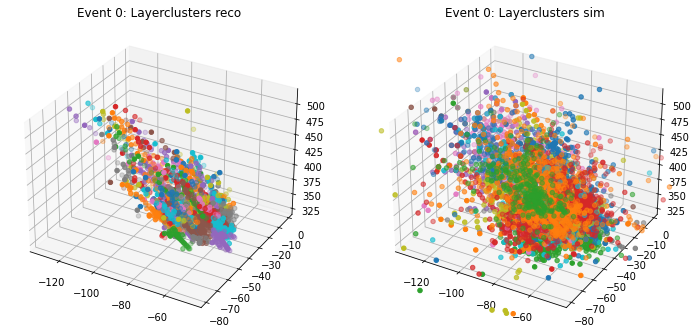

In [4]:
for i, (eid, it) in enumerate(incomplete_tracksters[:1]):
    print(f"Event {eid}: complete: {complete_tracksters[i][1]} incomplete : {it}")
    plot_event(tracksters, simtracksters, eid, legend=False)

In [5]:
# find the correct trackster to merge with
# returns: eid, index, candidate, label
pairs = get_pairs(incomplete_tracksters, associations, h_frac)

Pairs: 5770 No candidates: 2 Merging with itself: 42


### Create the dataset

In [8]:
trackster_x = []
trackster_y = []
trackster_z = []
trackster_energy = []

candidate_x = []
candidate_y = []
candidate_z = []
candidate_energy = []

pair_label = []
pair_event = []
pair_fileid = []

datadir = "~/data/multiparticle"

for fileid in range(900, 910):
    datafile = f"new_ntuples_14132277_{fileid}.root"
    print("Processing file:", datafile)
    filepath = f"{datadir}/{datafile}"
    try:
        tracksters = uproot.open({filepath: "ticlNtuplizer/tracksters"})
        simtracksters = uproot.open({filepath: "ticlNtuplizer/simtrackstersSC"})
        associations = uproot.open({filepath: "ticlNtuplizer/associations"})
    except:
        print("file not found:", datafile)
        continue

    _, split_eids = get_eid_splits(tracksters, simtracksters, associations)
    h_frac = {eid:get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid) for eid in split_eids}

    _, incomplete_tracksters = split_on_shared_energy(tracksters, simtracksters, h_frac, split_eids)
    pairs = get_pairs(incomplete_tracksters, associations, h_frac)

    vx = tracksters["vertices_x"].array()
    vy = tracksters["vertices_y"].array()
    vz = tracksters["vertices_z"].array()
    ve = tracksters["vertices_energy"].array()

    for eid, trackster_id, candidate_id, label in pairs:
        trackster_x.append(vx[eid][trackster_id])
        trackster_y.append(vy[eid][trackster_id])
        trackster_z.append(vz[eid][trackster_id])
        trackster_energy.append(ve[eid][trackster_id])

        candidate_x.append(vx[eid][candidate_id])
        candidate_y.append(vy[eid][candidate_id])
        candidate_z.append(vz[eid][candidate_id])
        candidate_energy.append(ve[eid][candidate_id])

        pair_event.append(eid)
        pair_label.append(label)
        pair_fileid.append(fileid)

Processing file: new_ntuples_14132277_900.root
Total reco tracksters: 3733, complete: 318, Incomplete: 2833
Pairs: 5564 No candidates: 2 Merging with itself: 49
Processing file: new_ntuples_14132277_901.root
Total reco tracksters: 3823, complete: 323, Incomplete: 2923
Pairs: 5738 No candidates: 1 Merging with itself: 53
Processing file: new_ntuples_14132277_902.root
Total reco tracksters: 3695, complete: 331, Incomplete: 2795
Pairs: 5466 No candidates: 3 Merging with itself: 59
Processing file: new_ntuples_14132277_903.root
Total reco tracksters: 3763, complete: 326, Incomplete: 2863
Pairs: 5616 No candidates: 0 Merging with itself: 55
Processing file: new_ntuples_14132277_904.root
Total reco tracksters: 3779, complete: 323, Incomplete: 2879
Pairs: 5656 No candidates: 3 Merging with itself: 48
Processing file: new_ntuples_14132277_905.root
Total reco tracksters: 3918, complete: 319, Incomplete: 3018
Pairs: 5920 No candidates: 0 Merging with itself: 58
Processing file: new_ntuples_14132

In [9]:
ds = uproot.recreate("data/trackster_pairs_200e_multi.root")
ds["tracksters"] = {
    "trackster_x": trackster_x,
    "trackster_y": trackster_y,
    "trackster_z": trackster_z,
    "trackster_energy": trackster_energy,
    "candidate_x": candidate_x,
    "candidate_y": candidate_y,
    "candidate_z": candidate_z,
    "candidate_energy": candidate_energy,
    "pair_label": pair_label,
    "pair_event": pair_event,
    "pair_fileid": pair_fileid,
}
ds.close()